### Imports

In [1858]:
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

import collections

## 1. Load Dataset

In [1859]:
incidents_df = pd.read_csv("data/incidents.csv")

/var/folders/6w/gs5ftqnj599ct2q_7plmjnk00000gn/T/ipykernel_37318/1719764553.py:1: DtypeWarning: Columns (15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  incidents_df = pd.read_csv("data/incidents.csv")


In [1860]:
incidents_df.isna().sum() / incidents_df.shape[0] * 100

date                          0.000000
state                         0.000000
city_or_county                0.000000
address                       6.883013
latitude                      3.305699
longitude                     3.305699
congressional_district        4.983373
state_house_district         16.176771
state_senate_district        13.491073
participant_age1             38.509327
participant_age_group1       17.573234
participant_gender1          15.171251
min_age_participants         31.207834
avg_age_participants         31.133567
max_age_participants         31.170283
n_participants_child         17.566976
n_participants_teen          17.564889
n_participants_adult         17.566141
n_males                      15.171251
n_females                    15.171251
n_killed                      0.000000
n_injured                     0.000000
n_arrested                   11.526346
n_unharmed                   11.526346
n_participants                0.000000
notes                    

In [1861]:
def convert_dtype(x):
    if not x:
        return np.NaN
    try:
        return float(x)
    except:
        print(f"Wrong type (removed): {x}")
        return "syntactically wrong"

In [1862]:
incidents_df = pd.read_csv(
    "data/incidents.csv",
    converters={
        "n_participants_child": convert_dtype,
        "n_participants_teen": convert_dtype,
        "n_participants_adult": convert_dtype,
        "min_age_participants": convert_dtype,
        "avg_age_participants": convert_dtype,
        "max_age_participants": convert_dtype,
    },
)

Wrong type (removed): 3jjvqoij9
Wrong type (removed): ok9nkr
Wrong type (removed): reqcd7b9l
Wrong type (removed): h8m7d
Wrong type (removed): tb1qgofw1
Wrong type (removed): yk3zx8977
Wrong type (removed): 4skvo
Wrong type (removed): hpgj2c
Wrong type (removed): 756v9l4
Wrong type (removed): z1bns
Wrong type (removed): kdns
Wrong type (removed): bbj8mebn53
Wrong type (removed): mx9enzo
Wrong type (removed): lxq
Wrong type (removed): vioyrxxk
Wrong type (removed): cf4q15913x
Wrong type (removed): l87bf9p7
Wrong type (removed): 2kvc779qf
Wrong type (removed): rs4j
Wrong type (removed): vf43p
Wrong type (removed): xfy12nfv
Wrong type (removed): 6oz9e3i5
Wrong type (removed): hgo4zrwh
Wrong type (removed): mvfytej
Wrong type (removed): r80
Wrong type (removed): u32
Wrong type (removed): jhzn
Wrong type (removed): d40wc
Wrong type (removed): 3kh
Wrong type (removed): 6bknw8
Wrong type (removed): s9b9c47o
Wrong type (removed): rwbpvv
Wrong type (removed): 8rij3
Wrong type (removed): d94nt2q

/var/folders/6w/gs5ftqnj599ct2q_7plmjnk00000gn/T/ipykernel_37318/2325330659.py:1: DtypeWarning: Columns (15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  incidents_df = pd.read_csv(


In [1863]:
incidents_df.shape[0] - incidents_df.drop_duplicates().shape[0]

296

In [1864]:
incidents_df = incidents_df.drop_duplicates(ignore_index=True)

In [1865]:
poverty_df = pd.read_csv("data/povertyByStateYear.csv")

poverty_df

,state,year,povertyPercentage
0,United States,2020,11.5
1,Alabama,2020,14.8
2,Alaska,2020,11.5
3,Arizona,2020,12.1
4,Arkansas,2020,15.8
...,...,...,...
879,Virginia,2004,9.1
880,Washington,2004,9.8
881,West Virginia,2004,15.0
882,Wisconsin,2004,10.9


In [1866]:
district_house_df = pd.read_csv("data/year_state_district_house.csv")
district_house_df

,year,state,congressional_district,party,candidatevotes,totalvotes
0,1976,ALABAMA,1,REPUBLICAN,98257,157170
1,1976,ALABAMA,2,REPUBLICAN,90069,156362
2,1976,ALABAMA,3,DEMOCRAT,106935,108048
3,1976,ALABAMA,4,DEMOCRAT,141490,176022
4,1976,ALABAMA,5,DEMOCRAT,113553,113560
...,...,...,...,...,...,...
10436,2022,WISCONSIN,5,REPUBLICAN,243741,378523
10437,2022,WISCONSIN,6,REPUBLICAN,239231,251999
10438,2022,WISCONSIN,7,REPUBLICAN,209224,338268
10439,2022,WISCONSIN,8,REPUBLICAN,223981,310196


In [1867]:
np.min(incidents_df["congressional_district"])

0.0

In [1868]:
np.max(incidents_df["congressional_district"])

53.0

## 2. Data Quality Assessment

### Syntactic accuracy

In [1869]:
wrong_type_vars = [
    "n_participants_child",
    "n_participants_teen",
    "n_participants_adult",
    "min_age_participants",
    "avg_age_participants",
    "max_age_participants",
]

for var in wrong_type_vars:
    print(var)
    print(
        incidents_df.loc[incidents_df[var] == "syntactically wrong"].shape[0]
        / incidents_df.shape[0]
        * 100
    )

n_participants_child
0.002088720491601255
n_participants_teen
0.002924208688241757
n_participants_adult
0.001253232294960753
min_age_participants
2.403281797636404
avg_age_participants
2.460094995007958
max_age_participants
2.4584240186146773


Now I can change these error to NaN values.

In [1870]:
for var in wrong_type_vars:
    incidents_df.loc[incidents_df[var] == "syntactically wrong", var] = np.NaN

In [1871]:
incidents_df["participant_age_group1"].unique()

array(['Adult 18+', nan, 'Teen 12-17', 'Child 0-11'], dtype=object)

### Semantic Accuracy

In [1872]:
incidents_df.insert(
    1, "year", [int(incidents_df["date"][i][0:4]) for i in range(incidents_df.shape[0])]
)

There are a lot of incidents with a wrong date. For the moment, we consider these years as missing values, but we keep the information about the date, which will be useful to try to correct the year of the incident.

In [1873]:
print(
    incidents_df.loc[incidents_df["year"] > 2018, "year"].shape[0]
    / incidents_df.shape[0]
    * 100
)
print(
    incidents_df.loc[incidents_df["year"] < 2013, "year"].shape[0]
    / incidents_df.shape[0]
    * 100
)

9.611456214152335
0.0


In [1874]:
incidents_df.loc[incidents_df["year"] > 2018, "year"] = np.NaN
incidents_df.loc[incidents_df["year"] < 2013, "year"] = np.NaN

We also verify that in 2018 recordings stop on March 31st.

In [1875]:
tdf = incidents_df.loc[incidents_df["year"] == 2018]
tdf.sort_values("date").tail()

,date,year,state,city_or_county,address,latitude,longitude,congressional_district,state_house_district,state_senate_district,...,n_males,n_females,n_killed,n_injured,n_arrested,n_unharmed,n_participants,notes,incident_characteristics1,incident_characteristics2
25073,2018-03-31,2018.0,Massachusetts,Cambridge,Village St,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0,NaN,NaN,0.0,shotspotter,Shots Fired - No Injuries,ShotSpotter
237046,2018-03-31,2018.0,Michigan,Detroit,Patton St and Pilgrim St,42.4060,-83.2439,13.0,8.0,3.0,...,2.0,0.0,0,2,0.0,0.0,2.0,NaN,Shot - Wounded/Injured,NaN
219059,2018-03-31,2018.0,Mississippi,West Point,110 Hwy 45 S,33.6073,-88.6590,1.0,37.0,16.0,...,1.0,0.0,0,0,1.0,0.0,1.0,NaN,Institution/Group/Business,Shots Fired - No Injuries
40144,2018-03-31,2018.0,Illinois,Dekalb,1300 block of N Annie Glidden Rd,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,1,0,0.0,0.0,1.0,Woman shot at party; stable;,Shot - Wounded/Injured,House party
189336,2018-03-31,2018.0,Maine,Bangor,Ohio St,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0,0,1.0,0.0,1.0,"poss shots fired during dv, arrest on W Broadw...",Shots Fired - No Injuries,Domestic Violence


We check if there are negative values for variables that we expect to be non-negative. 
We also want to remove improbable (too large) age values. We symbolically consider the maximum acceptable age to be 116, which is the oldest man on Earth's age.

In [1876]:
non_negative_vars = [
    "congressional_district",
    "state_house_district",
    "state_senate_district",
    "participant_age1",
    "min_age_participants",
    "avg_age_participants",
    "max_age_participants",
    "n_participants_child",
    "n_participants_teen",
    "n_participants_adult",
    "n_males",
    "n_females",
    "n_killed",
    "n_injured",
    "n_arrested",
    "n_unharmed",
    "n_participants",
]

age_vars = [
    "participant_age1",
    "min_age_participants",
    "avg_age_participants",
    "max_age_participants",
]

for var in non_negative_vars:
    print(var)
    tmp = incidents_df.loc[incidents_df[var].notna()]
    if var in age_vars:
        print(
            tmp.loc[tmp[var] < 0].shape[0] / incidents_df.shape[0] * 100
            + tmp.loc[tmp[var] > 116].shape[0] / incidents_df.shape[0] * 100
        )
        incidents_df.loc[incidents_df[var] < 0, var] = np.NaN
        incidents_df.loc[incidents_df[var] > 116, var] = np.NaN
    else:
        print(tmp.loc[tmp[var] < 0].shape[0] / incidents_df.shape[0] * 100)
        incidents_df.loc[incidents_df[var] < 0, var] = np.NaN

congressional_district
0.0
state_house_district
0.0
state_senate_district
0.0
participant_age1
0.000835488196640502
min_age_participants
4.906404434771348
avg_age_participants
4.9256206632940795
max_age_participants
4.890112414936858
n_participants_child
0.001670976393281004
n_participants_teen
0.00417744098320251
n_participants_adult
0.003341952786562008
n_males
0.0
n_females
0.0
n_killed
0.0
n_injured
0.0
n_arrested
0.0
n_unharmed
0.0
n_participants
0.0


Other variables that should be constrained in a specific range are coordinates. Now, to be precise we should check that all coordinates match the respsective county or city, but here we just investigate cases where coordinates are not in the USA.

In [1877]:
print(np.min(incidents_df["latitude"]))
print(np.max(incidents_df["latitude"]))
print(np.min(incidents_df["longitude"]))
print(np.max(incidents_df["longitude"]))

19.1114
71.3368
-171.429
97.4331


In [1878]:
incidents_df.loc[incidents_df["longitude"] > -60]

,date,year,state,city_or_county,address,latitude,longitude,congressional_district,state_house_district,state_senate_district,...,n_males,n_females,n_killed,n_injured,n_arrested,n_unharmed,n_participants,notes,incident_characteristics1,incident_characteristics2
30346,2018-03-29,2018.0,Kansas,Wichita,NaN,37.6499,97.4331,NaN,NaN,NaN,...,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,Non-Shooting Incident,TSA Action
102685,2018-03-25,2018.0,Kansas,Wichita,NaN,37.6499,97.4331,NaN,NaN,NaN,...,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,Non-Shooting Incident,TSA Action
156465,2018-03-20,2018.0,Nebraska,Lincoln,NaN,40.8509,96.7591,NaN,NaN,NaN,...,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,Non-Shooting Incident,TSA Action
174483,2017-12-22,2017.0,North Carolina,Charlotte,NaN,35.2137,80.9491,NaN,NaN,NaN,...,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,Non-Shooting Incident,TSA Action
196792,2017-11-15,2017.0,Missouri,St Louis,NaN,38.7487,90.3700,NaN,NaN,NaN,...,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,Non-Shooting Incident,TSA Action


In [1879]:
incidents_df.loc[incidents_df["longitude"] > -60, "longitude"] = np.NaN

Fortunately, there are only 5 cases where the longitude attribute seems wrong. So we can try to check if changing the sign of the longitude is consistent with the rest of the information on the location.

Using google maps, we verify that all the 5 locations match if the lognitude's sign is reverse. Moreover, these 5 incidents are all TSA Actions in different airports.

We can now correct the coordinates.

In [1880]:
incidents_df.loc[incidents_df["longitude"] > -60, "longitude"] = -incidents_df.loc[
    incidents_df["longitude"] > -60, "longitude"
]

In [1881]:
tmp_notna = incidents_df.loc[incidents_df["min_age_participants"].notna()]
tmp_notna = tmp_notna.loc[tmp_notna["max_age_participants"].notna()]
tmp_notna = tmp_notna.loc[tmp_notna["avg_age_participants"].notna()]

tmp = tmp_notna.loc[
    tmp_notna["max_age_participants"] >= tmp_notna["avg_age_participants"]
]
tmp = tmp.loc[tmp["min_age_participants"] <= tmp["avg_age_participants"]]

tmp.shape[0] / tmp_notna.shape[0] * 100

100.0

In [1882]:
tmp_notna = incidents_df.loc[incidents_df["min_age_participants"].notna()]
tmp_notna = tmp_notna.loc[tmp_notna["max_age_participants"].notna()]
tmp_notna = tmp_notna.loc[tmp_notna["participant_age1"].notna()]

tmp = tmp_notna.loc[tmp_notna["max_age_participants"] >= tmp_notna["participant_age1"]]
tmp = tmp.loc[tmp["min_age_participants"] <= tmp["participant_age1"]]

tmp.shape[0] / tmp_notna.shape[0] * 100

100.0

Now we check that the number of a special categrory of participants if not larger than the total number of participants.

In [1883]:
for col in [
    "n_killed",
    "n_injured",
    "n_unharmed",
    "n_arrested",
    "n_participants_child",
    "n_participants_teen",
    "n_participants_adult",
    "n_males",
    "n_females",
]:
    print(col)
    tmp_notna = incidents_df.loc[incidents_df[col].notna()]
    tmp = tmp_notna.loc[tmp_notna[col] > tmp_notna["n_participants"]]

    print(tmp.shape[0] / tmp_notna.shape[0] * 100)

    incidents_df[col][tmp.index] = np.NaN

n_killed
0.0
n_injured
0.0
n_unharmed
0.0
n_arrested
0.0
n_participants_child
0.0030377593487043958
n_participants_teen
0.0015189027446572596
n_participants_adult
0.0030377593487043958
n_males
0.0
n_females
0.0


Another thing that we may want to check is the information about the number of participants.
We expect the fllowing equalities to hold:
* n_participants = n_males + n_females 
* n_participants = n_participants_child + n_participants_teen + n_participants_adult
* n_participants = n_killed + n_unharmed + n_injured 
or
* n_participants = n_killed + n_unharmed + n_injured + n_arrested

In [1884]:
tmp_notna = incidents_df.loc[incidents_df["n_killed"].notna()]
tmp_notna = tmp_notna.loc[tmp_notna["n_injured"].notna()]
tmp_notna = tmp_notna.loc[tmp_notna["n_unharmed"].notna()]
tmp_notna = tmp_notna.loc[tmp_notna["n_arrested"].notna()]
tmp_notna = tmp_notna.loc[tmp_notna["n_participants"].notna()]

tmp = tmp_notna.loc[
    tmp_notna["n_killed"]
    + tmp_notna["n_injured"]
    + tmp_notna["n_unharmed"]
    + tmp_notna["n_arrested"]
    == tmp_notna["n_participants"]
]

tmp.shape[0] / tmp_notna.shape[0] * 100

95.021888031398

In [1885]:
tmp_notna = incidents_df.loc[incidents_df["n_participants_child"].notna()]
tmp_notna = tmp_notna.loc[tmp_notna["n_participants_teen"].notna()]
tmp_notna = tmp_notna.loc[tmp_notna["n_participants_adult"].notna()]
tmp_notna = tmp_notna.loc[tmp_notna["n_participants"].notna()]

tmp = tmp_notna.loc[
    tmp_notna["n_participants_child"]
    + tmp_notna["n_participants_teen"]
    + tmp_notna["n_participants_adult"]
    == tmp_notna["n_participants"]
]

tmp.shape[0] / tmp_notna.shape[0] * 100

90.13002004982077

In [1886]:
tmp_notna = incidents_df.loc[incidents_df["n_males"].notna()]
tmp_notna = tmp_notna.loc[tmp_notna["n_females"].notna()]
tmp_notna = tmp_notna.loc[tmp_notna["n_participants"].notna()]

tmp = tmp_notna.loc[
    tmp_notna["n_males"] + tmp_notna["n_females"] == tmp_notna["n_participants"]
]

tmp.shape[0] / tmp_notna.shape[0] * 100

92.04835043735794

Even if the count is not always correct, for now we keep the information about the group composition as it could still be useful. Also because it would be difficult to identify the incorrect value among the different attributes in the sum.

In [1887]:
incidents_df.loc[incidents_df["n_participants"] == 0].shape[0] / incidents_df.shape[
    0
] * 100

10.289037141627782

In [1888]:
for var in [
    "n_males",
    "n_females",
    "n_killed",
    "n_injured",
    "n_unharmed",
    "n_arrested",
    "n_participants_adult",
    "n_participants_teen",
    "n_participants_child",
]:
    print(
        incidents_df.loc[
            (incidents_df["n_participants"] == 0) & (incidents_df[var] > 0)
        ].shape[0]
    )

0
0
0
0
0
0
0
0
0


In [1889]:
incidents_df.loc[incidents_df["n_participants"] == 0, "n_participants"] = np.NaN

In [1890]:
(incidents_df.isnull().sum() / incidents_df.shape[0]) * 100

date                          0.000000
year                          9.611456
state                         0.000000
city_or_county                0.000000
address                       6.870637
latitude                      3.309786
longitude                     3.311875
congressional_district        4.989118
state_house_district         16.180482
state_senate_district        13.495641
participant_age1             38.442065
participant_age_group1       17.492199
participant_gender1          15.086828
min_age_participants         38.440394
avg_age_participants         38.442065
max_age_participants         38.441647
n_participants_child         17.492199
n_participants_teen          17.492199
n_participants_adult         17.492199
n_males                      15.086828
n_females                    15.086828
n_killed                      0.000000
n_injured                     0.000000
n_arrested                   11.443264
n_unharmed                   11.443264
n_participants           

### Data Integration

In [1891]:
joined_df = incidents_df.copy()

In [1892]:
joined_df["povertyPercentage"] = " "
joined_df["party"] = " "
joined_df["candidatevotes"] = " "
joined_df["totalvotes"] = " "

valid dates: 1/1/2013 to 31/3/2018. \
there are a lot of incidents with wrong dates (2028-2030). \
Ho googlato un po' di notizie usando le note del dataset, le città ecc. e sembra che 2028->2013; 2029->2014; 2030->2015. (Non si possono controllare uno a uno perché sono migliaia, quindi ne estraiamo un po' a caso e ci fidiamo?)

In [1893]:
pd.options.mode.chained_assignment = None

for i in range(joined_df.shape[0]):
    if int(joined_df["date"][i][0:4]) > 2018:
        joined_df["year"][i] = int(joined_df["date"][i][0:4]) - 15

In [1894]:
for i in range(joined_df.shape[0]):
    povertyPercentage = poverty_df.loc[
        (poverty_df["year"] == joined_df.loc[i, "year"])
        & (poverty_df["state"] == joined_df.loc[i, "state"]),
        "povertyPercentage",
    ].values

    if len(povertyPercentage) == 1:
        joined_df["povertyPercentage"][i] = povertyPercentage[0]
    else:
        joined_df["povertyPercentage"][i] = np.NaN

Congressional elections occur every 2 years!

In [1895]:
for i in range(joined_df.shape[0]):
    party = district_house_df.loc[
        (district_house_df["year"] // 2 == joined_df["year"][i] // 2)
        & (district_house_df["state"] == joined_df["state"][i].upper())
        & (
            district_house_df["congressional_district"]
            == joined_df["congressional_district"][i]
        ),
        "party",
    ].values

    if len(party) == 1:
        joined_df["party"][i] = party[0]
    else:
        joined_df["party"][i] = " "

In [1896]:
for i in range(joined_df.shape[0]):
    candidatevotes = district_house_df.loc[
        (district_house_df["year"] // 2 == joined_df.loc[i, "year"] // 2)
        & (district_house_df["state"] == joined_df.loc[i, "state"].upper())
        & (
            district_house_df["congressional_district"]
            == joined_df.loc[i, "congressional_district"]
        ),
        "candidatevotes",
    ].values

    if len(candidatevotes) == 1:
        joined_df["candidatevotes"][i] = candidatevotes[0]
    else:
        joined_df["candidatevotes"][i] = np.NaN

In [1897]:
for i in range(joined_df.shape[0]):
    totalvotes = district_house_df.loc[
        (district_house_df["year"] // 2 == joined_df.loc[i, "year"] // 2)
        & (district_house_df["state"] == joined_df.loc[i, "state"].upper())
        & (
            district_house_df["congressional_district"]
            == joined_df.loc[i, "congressional_district"]
        ),
        "totalvotes",
    ].values

    if len(totalvotes) == 1:
        joined_df["totalvotes"][i] = totalvotes[0]
    else:
        joined_df["totalvotes"][i] = np.NaN

In [1898]:
joined_df

,date,year,state,city_or_county,address,latitude,longitude,congressional_district,state_house_district,state_senate_district,...,n_arrested,n_unharmed,n_participants,notes,incident_characteristics1,incident_characteristics2,povertyPercentage,party,candidatevotes,totalvotes
0,2015-05-02,2015.0,Indiana,Indianapolis,Lafayette Road and Pike Plaza,39.8322,-86.2492,7.0,94.0,33.0,...,0.0,0.0,1.0,Teen wounded while walking - Security guard at...,Shot - Wounded/Injured,NaN,12.3,DEMOCRAT,61443,112261
1,2017-04-03,2017.0,Pennsylvania,Kane,5647 US 6,41.6645,-78.7856,5.0,NaN,NaN,...,0.0,0.0,1.0,shot self after accident,"Shot - Dead (murder, accidental, suicide)",Suicide^,10.5,REPUBLICAN,206761,307843
2,2016-11-05,2016.0,Michigan,Detroit,6200 Block of East McNichols Road,42.4190,-83.0393,14.0,4.0,2.0,...,0.0,1.0,2.0,1 inj.,Shot - Wounded/Injured,NaN,11.0,DEMOCRAT,244135,310974
3,2016-10-15,2016.0,District of Columbia,Washington,"1000 block of Bladensburg Road, NE",38.9030,-76.9820,1.0,NaN,NaN,...,0.0,0.0,2.0,NaN,Shot - Wounded/Injured,NaN,14.9,,NaN,NaN
4,2030-06-14,2015.0,Pennsylvania,Pittsburgh,California and Marshall Avenues,40.4621,-80.0308,14.0,NaN,NaN,...,0.0,1.0,2.0,NaN,Shot - Wounded/Injured,"Drive-by (car to street, car to car)",11.5,DEMOCRAT,148351,148351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239376,2016-01-11,2016.0,Tennessee,Murfreesboro,Hazelwood Street,35.8624,-86.3695,4.0,37.0,14.0,...,0.0,0.0,1.0,"Tried to grab gun as it fell, shot self in foot.",Shot - Wounded/Injured,Non-Aggression Incident,12.6,REPUBLICAN,165796,254937
239377,2029-01-01,2014.0,New York,Troy,Pawling and Plum Avenues,42.7043,-73.6590,20.0,108.0,44.0,...,0.0,3.0,3.0,NaN,Armed robbery with injury/death and/or evidenc...,NaN,13.4,DEMOCRAT,103437,211965
239378,2017-08-17,2017.0,Tennessee,Memphis,Barron Ave and Pendleton St,35.1007,-89.9700,9.0,93.0,33.0,...,0.0,0.0,1.0,"Orange Mound, man shot",Shot - Wounded/Injured,NaN,12.1,DEMOCRAT,171631,217957
239379,2016-06-07,2016.0,Colorado,Colorado Springs,601 Prospect Lake Drive,38.8251,-104.8020,5.0,18.0,11.0,...,1.0,1.0,2.0,Record ID 22972 on Colorado Springs Police Dep...,Non-Shooting Incident,Possession of gun by felon or prohibited person,8.9,REPUBLICAN,225445,361993


In [1899]:
joined_df.to_csv("data/joined_dataset.csv", index=False)

## 3. Data preparation

### Fill missing values

In [2073]:
joined_df = pd.read_csv("data/joined_dataset.csv")

In [2074]:
def fill_missing_randomly_within_group(df, value_column, group_columns=[]):
    if len(group_columns) > 0:
        grouped = df.groupby(group_columns)
        for _, group_df in grouped:
            non_missing_values = group_df[value_column].dropna()
            missing_indices = group_df.index[group_df[value_column].isnull()]
            if non_missing_values.shape[0] > 0:
                random_values = np.random.choice(
                    non_missing_values, size=len(missing_indices)
                )
                df.loc[missing_indices, value_column] = random_values
    else:
        non_missing_values = df[value_column].dropna()
        missing_indices = df.index[df[value_column].isnull()]
        if non_missing_values.shape[0] > 0:
            random_values = np.random.choice(
                non_missing_values, size=len(missing_indices)
            )
            df.loc[missing_indices, value_column] = random_values

    return df

#### 1. Coordinates

In [2075]:
joined_df = fill_missing_randomly_within_group(
    joined_df, "latitude", ["state", "city_or_county"]
)
joined_df = fill_missing_randomly_within_group(
    joined_df, "longitude", ["state", "city_or_county"]
)

If we have no info about city, we use states:

In [2076]:
joined_df = fill_missing_randomly_within_group(joined_df, "latitude", ["state"])
joined_df = fill_missing_randomly_within_group(joined_df, "longitude", ["state"])

#### 2. Age

In [2077]:
joined_df["min_age_participants"] = (
    joined_df["avg_age_participants"] - joined_df["min_age_participants"]
)
joined_df["max_age_participants"] = (
    joined_df["max_age_participants"] - joined_df["avg_age_participants"]
)

In [2078]:
joined_df = fill_missing_randomly_within_group(
    joined_df, "min_age_participants", ["state"]
)
joined_df = fill_missing_randomly_within_group(
    joined_df, "avg_age_participants", ["state"]
)
joined_df = fill_missing_randomly_within_group(
    joined_df, "max_age_participants", ["state"]
)

In [2079]:
joined_df["min_age_participants"] = (
    joined_df["avg_age_participants"] - joined_df["min_age_participants"]
)
joined_df["max_age_participants"] = (
    joined_df["max_age_participants"] + joined_df["avg_age_participants"]
)

#### 3. Participants

In [2080]:
joined_df = fill_missing_randomly_within_group(
    joined_df, "n_participants", ["state", "year"]
)
joined_df["n_participants"] = joined_df["n_participants"].astype(int)

males/females

In [2081]:
joined_df["n_males"] = joined_df["n_males"].div(joined_df["n_participants"])
joined_df = fill_missing_randomly_within_group(joined_df, "n_males", ["state"])
joined_df["n_males"] = (joined_df["n_males"] * joined_df["n_participants"]).astype(int)

In [2082]:
joined_df["n_females"] = joined_df["n_participants"] - joined_df["n_males"].astype(int)

adults/teen/children

In [2083]:
joined_df["n_participants_adult"] = joined_df["n_participants_adult"].div(
    joined_df["n_participants"]
)
joined_df = fill_missing_randomly_within_group(
    joined_df, "n_participants_adult", ["state"]
)
joined_df["n_participants_adult"] = (
    joined_df["n_participants_adult"] * joined_df["n_participants"]
).astype(int)

In [2084]:
joined_df["n_participants_teen"] = joined_df["n_participants_teen"].div(
    (joined_df["n_participants"] - joined_df["n_participants_adult"]).replace(0, 1),
)
joined_df = fill_missing_randomly_within_group(
    joined_df, "n_participants_teen", ["state"]
)
joined_df["n_participants_teen"] = (
    joined_df["n_participants_teen"]
    * (joined_df["n_participants"] - joined_df["n_participants_adult"])
).astype(int)

In [2085]:
joined_df["n_participants_child"] = (
    joined_df["n_participants"]
    - joined_df["n_participants_adult"]
    - joined_df["n_participants_teen"]
).astype(int)

killed/injured/arrested/unharmed

In [2086]:
joined_df["n_killed"] = joined_df["n_killed"].div(joined_df["n_participants"])
joined_df = fill_missing_randomly_within_group(joined_df, "n_killed")
joined_df["n_killed"] = (joined_df["n_killed"] * joined_df["n_participants"]).astype(
    int
)

In [2087]:
joined_df["n_injured"] = joined_df["n_injured"].div(
    (joined_df["n_participants"] - joined_df["n_killed"]).replace(0, 1),
)
joined_df = fill_missing_randomly_within_group(joined_df, "n_injured")
joined_df["n_injured"] = (
    joined_df["n_injured"] * (joined_df["n_participants"] - joined_df["n_killed"])
).astype(int)

In [2088]:
joined_df["n_arrested"] = joined_df["n_arrested"].div(
    (
        joined_df["n_participants"] - joined_df["n_killed"] - joined_df["n_injured"]
    ).replace(0, 1),
)
joined_df = fill_missing_randomly_within_group(joined_df, "n_arrested")
joined_df["n_arrested"] = (
    joined_df["n_arrested"]
    * (joined_df["n_participants"] - joined_df["n_killed"] - joined_df["n_injured"])
).astype(int)

In [2089]:
joined_df["n_unharmed"] = (
    joined_df["n_participants"]
    - joined_df["n_killed"]
    - joined_df["n_injured"]
    - joined_df["n_arrested"]
).astype(int)

#### 4. Party and votes

In [2090]:
joined_df.loc[joined_df["party"] == " ", "party"] = np.NaN
joined_df.loc[joined_df["totalvotes"] == 0, "totalvotes"] = np.NaN

In [2092]:
joined_df = fill_missing_randomly_within_group(
    joined_df, "party", ["state", "congressional_district"]
)
joined_df = fill_missing_randomly_within_group(
    joined_df, "party", ["state", "city_or_county", "year"]
)
joined_df = fill_missing_randomly_within_group(joined_df, "party", ["state", "year"])

joined_df = fill_missing_randomly_within_group(joined_df, "party", ["year"])

In [2096]:
joined_df = fill_missing_randomly_within_group(
    joined_df, "totalvotes", ["year", "state"]
)
joined_df = fill_missing_randomly_within_group(joined_df, "totalvotes", ["state"])
joined_df = fill_missing_randomly_within_group(joined_df, "totalvotes", ["year"])

In [2097]:
joined_df["candidatevotes"] = joined_df["candidatevotes"].div(joined_df["totalvotes"])

joined_df = fill_missing_randomly_within_group(joined_df, "candidatevotes", ["state"])
joined_df = fill_missing_randomly_within_group(joined_df, "candidatevotes", ["year"])

joined_df["candidatevotes"] = joined_df["candidatevotes"] * (joined_df["totalvotes"])

In [2098]:
print(joined_df[joined_df["party"].isna()].shape[0] / joined_df.shape[0])
print(joined_df[joined_df["totalvotes"].isna()].shape[0] / joined_df.shape[0])
print(joined_df[joined_df["candidatevotes"].isna()].shape[0] / joined_df.shape[0])

0.0
0.0
0.0


### Remove / modify attributes

In [2099]:
joined_df = joined_df.drop(
    columns=[
        "address",
        "city_or_county",
        "congressional_district",
        "state_house_district",
        "state_senate_district",
        "participant_age1",
        "participant_age_group1",
        "participant_gender1",
        "notes",
        "incident_characteristics1",
        "incident_characteristics2",
    ]
)

In [2100]:
joined_df.insert(
    1,
    "month",
    [int(incidents_df["date"][i][5:7]) for i in range(incidents_df.shape[0])],
)

joined_df = joined_df.drop(columns=["date"])

In [2101]:
joined_df["candidatevotes"] = joined_df["candidatevotes"].div(
    joined_df["totalvotes"], axis=0
)

In [2104]:
joined_df.isna().sum() / joined_df.shape[0] * 100

month                   0.0
year                    0.0
state                   0.0
latitude                0.0
longitude               0.0
min_age_participants    0.0
avg_age_participants    0.0
max_age_participants    0.0
n_participants_child    0.0
n_participants_teen     0.0
n_participants_adult    0.0
n_males                 0.0
n_females               0.0
n_killed                0.0
n_injured               0.0
n_arrested              0.0
n_unharmed              0.0
n_participants          0.0
povertyPercentage       0.0
party                   0.0
candidatevotes          0.0
totalvotes              0.0
dtype: float64

In [2105]:
joined_df[
    [
        "min_age_participants",
        "max_age_participants",
        "n_participants_child",
        "n_participants_teen",
        "n_participants_adult",
        "povertyPercentage",
    ]
] = joined_df[
    [
        "min_age_participants",
        "max_age_participants",
        "n_participants_child",
        "n_participants_teen",
        "n_participants_adult",
        "povertyPercentage",
    ]
].astype(
    float
)

In [2106]:
columns_to_normalize = [
    "n_arrested",
    "n_unharmed",
    "n_killed",
    "n_injured",
    "n_participants_adult",
    "n_participants_teen",
    "n_participants_child",
    "n_males",
    "n_females",
]

# Normalize columns by dividing each element by n_participants
joined_df[columns_to_normalize] = joined_df[columns_to_normalize].div(
    joined_df["n_participants"], axis=0
)

joined_df = joined_df.rename(
    columns={
        "n_arrested": "arrested_ratio",
        "n_unharmed": "unharmed_ratio",
        "n_killed": "killed_ratio",
        "n_injured": "injured_ratio",
        "n_participants_adult": "adults_ratio",
        "n_participants_teen": "teen_ratio",
        "n_participants_child": "children_ratio",
        "n_males": "males_ratio",
        "n_females": "females_ratio",
        "candidatevotes": "votes_ratio",
    }
)

In [2145]:
joined_df.loc[joined_df["party"] == "DEMOCRATIC-FARMER-LABOR", "party"] = "DEMOCRAT"

### Additional information

In [2146]:
population_df = pd.read_csv("data/population.csv")
population_df = population_df[["placeName", "Date:Count_Person", "Value:Count_Person"]]
population_df = population_df.astype({})
population_df = population_df.rename(
    columns={
        "placeName": "state",
        "Date:Count_Person": "year",
        "Value:Count_Person": "population",
    }
)

In [2147]:
joined_df["population"] = " "

for i in range(joined_df.shape[0]):
    year_condition = population_df["year"] == joined_df["year"][i]
    state_condition = population_df["state"] == joined_df["state"][i]
    population = population_df.loc[
        year_condition & state_condition, "population"
    ].values

    if len(population) == 1:
        joined_df["population"][i] = population[0]
    else:
        joined_df["population"][i] = np.NaN

## 4. Variables distribution

### Party

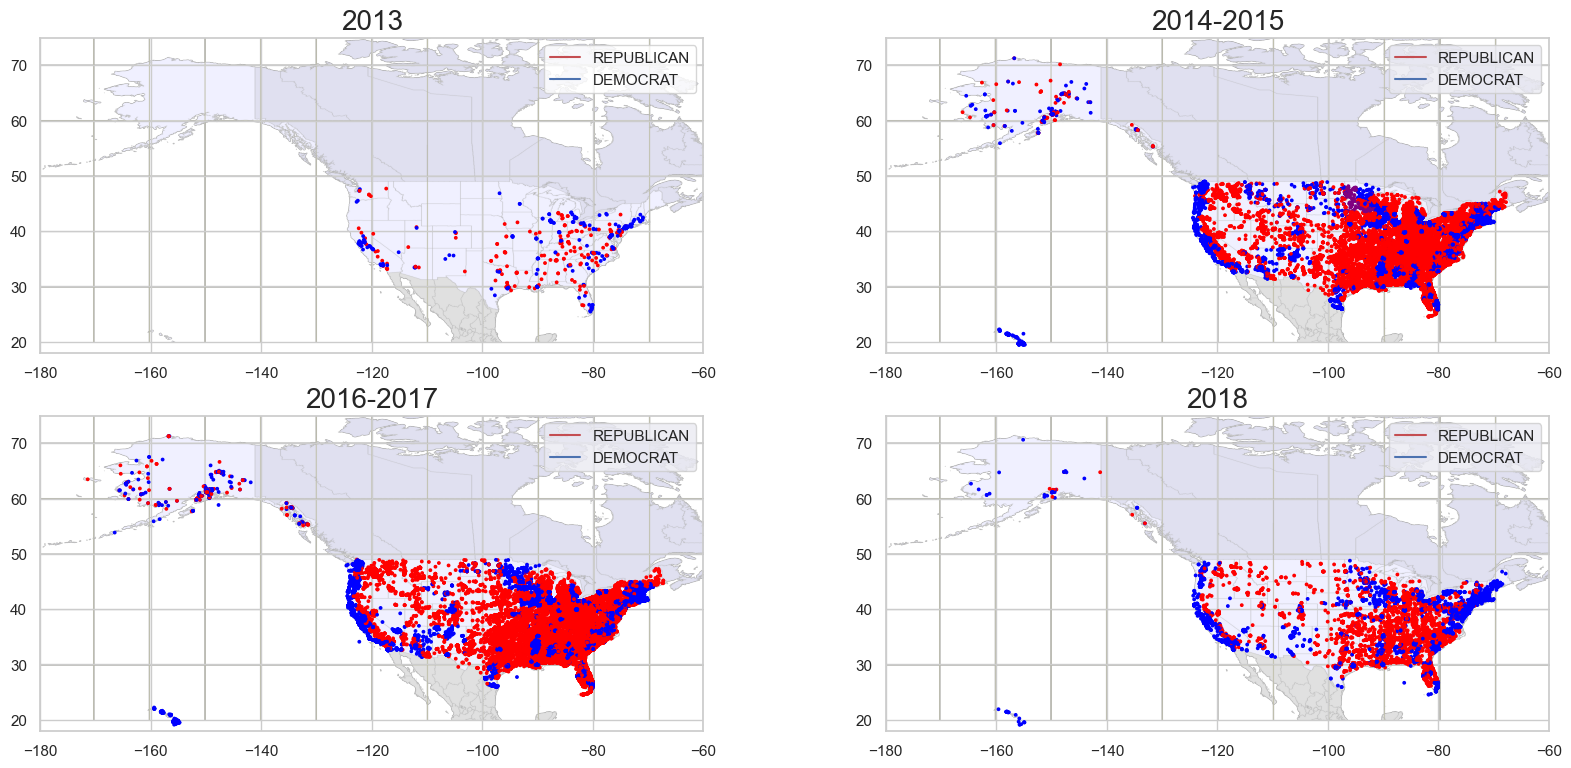

In [2132]:
sns.set_style("whitegrid")

colors = {
    "DEMOCRAT": "blue",
    "DEMOCRATIC-FARMER-LABOR": "purple",
    "REPUBLICAN": "red",
    " ": "gray",
}
usa = plt.imread("images/NorthAmerica.png")

fig, axs = plt.subplots(2, 2, figsize=(20, 9))
for i, y in enumerate([2012, 2014, 2016, 2018]):
    axs[i // 2, i % 2].imshow(usa, extent=[-180, -60, 20, 80])
    year_df = joined_df.loc[joined_df["year"] // 2 == y // 2]
    if y == 2012:
        axs[i // 2, i % 2].set_title(f"2013", fontsize=20)
    elif y == 2018:
        axs[i // 2, i % 2].set_title(f"2018", fontsize=20)
    else:
        axs[i // 2, i % 2].set_title(f"{y}-{y+1}", fontsize=20)
    axs[i // 2, i % 2].scatter(
        [year_df["longitude"][i] for i in year_df.index],
        [year_df["latitude"][i] for i in year_df.index],
        s=3,
        c=[colors[year_df["party"][i]] for i in year_df.index],
    )
    axs[i // 2, i % 2].set_xlim([-180, -60])
    axs[i // 2, i % 2].set_ylim([18, 75])
    axs[i // 2, i % 2].plot([0], "r", label="REPUBLICAN")
    axs[i // 2, i % 2].plot([0], "b", label="DEMOCRAT")
    axs[i // 2, i % 2].legend()

    sns.set(font_scale=1)

### Population

In [2134]:
import random
import matplotlib.colors as mcolors

# Generate a list of 50 random RGBA colors
random_colors = [
    (random.random(), random.random(), random.random(), random.uniform(0.5, 1.0))
    for _ in range(51)
]

colors = {}
state_list = list(joined_df.sort_values("state", ascending=False)["state"].unique())
for i, state in enumerate(state_list):
    colors[state] = random_colors[i]

import random

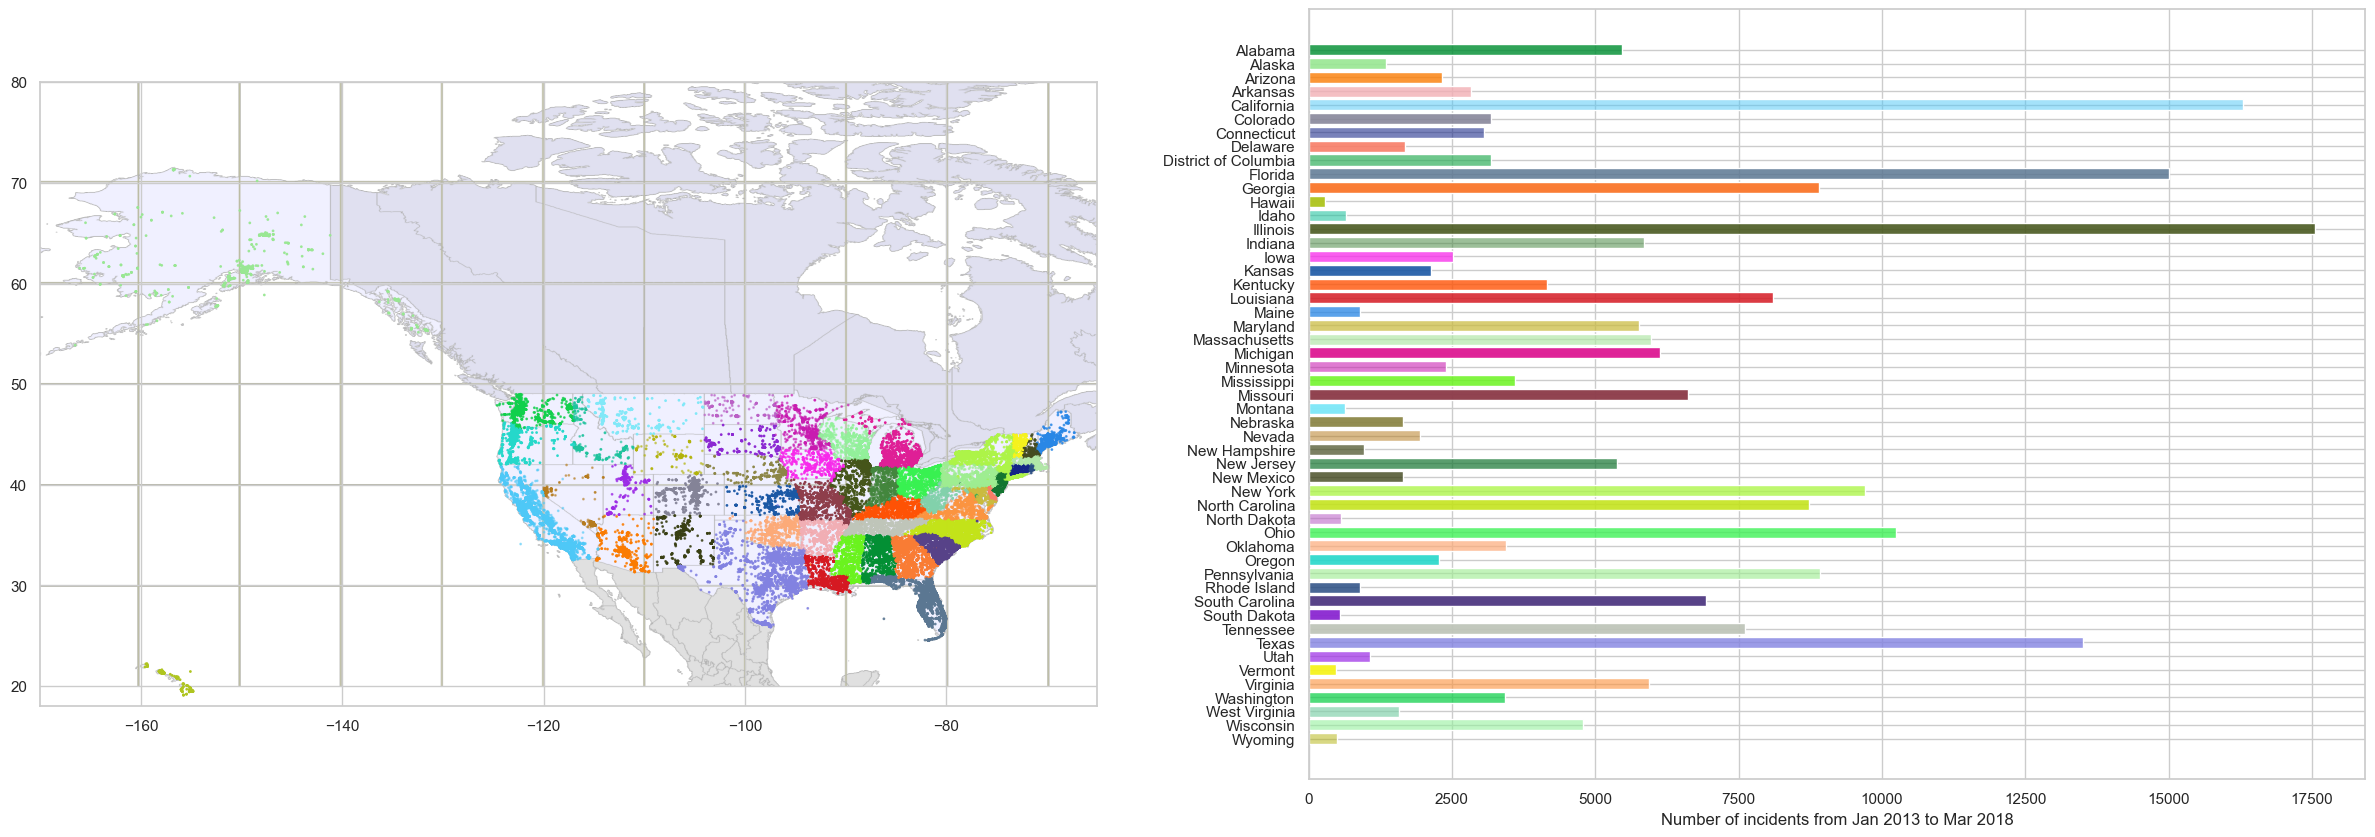

In [2136]:
sns.set_style("whitegrid")

usa = plt.imread("images/NorthAmerica.png")

fig, axs = plt.subplots(
    1,
    2,
    figsize=(30, 10),
    gridspec_kw={"height_ratios": [1], "width_ratios": [1, 1]},
)

axs[0].imshow(usa, extent=[-180, -60, 20, 80])
axs[0].scatter(
    [joined_df["longitude"][i] for i in joined_df.index],
    [joined_df["latitude"][i] for i in joined_df.index],
    s=1,
    c=[colors[joined_df["state"][i]] for i in joined_df.index],
)
axs[0].set_xlim([-170, -65])
axs[0].set_ylim([18, 80])

for i, value in enumerate(
    joined_df.sort_values("state", ascending=False)["state"].unique()
):
    count = joined_df.loc[joined_df["state"] == value].shape[0]
    axs[1].barh(value, count, color=random_colors[i])

axs[1].set_xlabel("Number of incidents from Jan 2013 to Mar 2018")
sns.set(font_scale=1.5)

### Poverty percentage

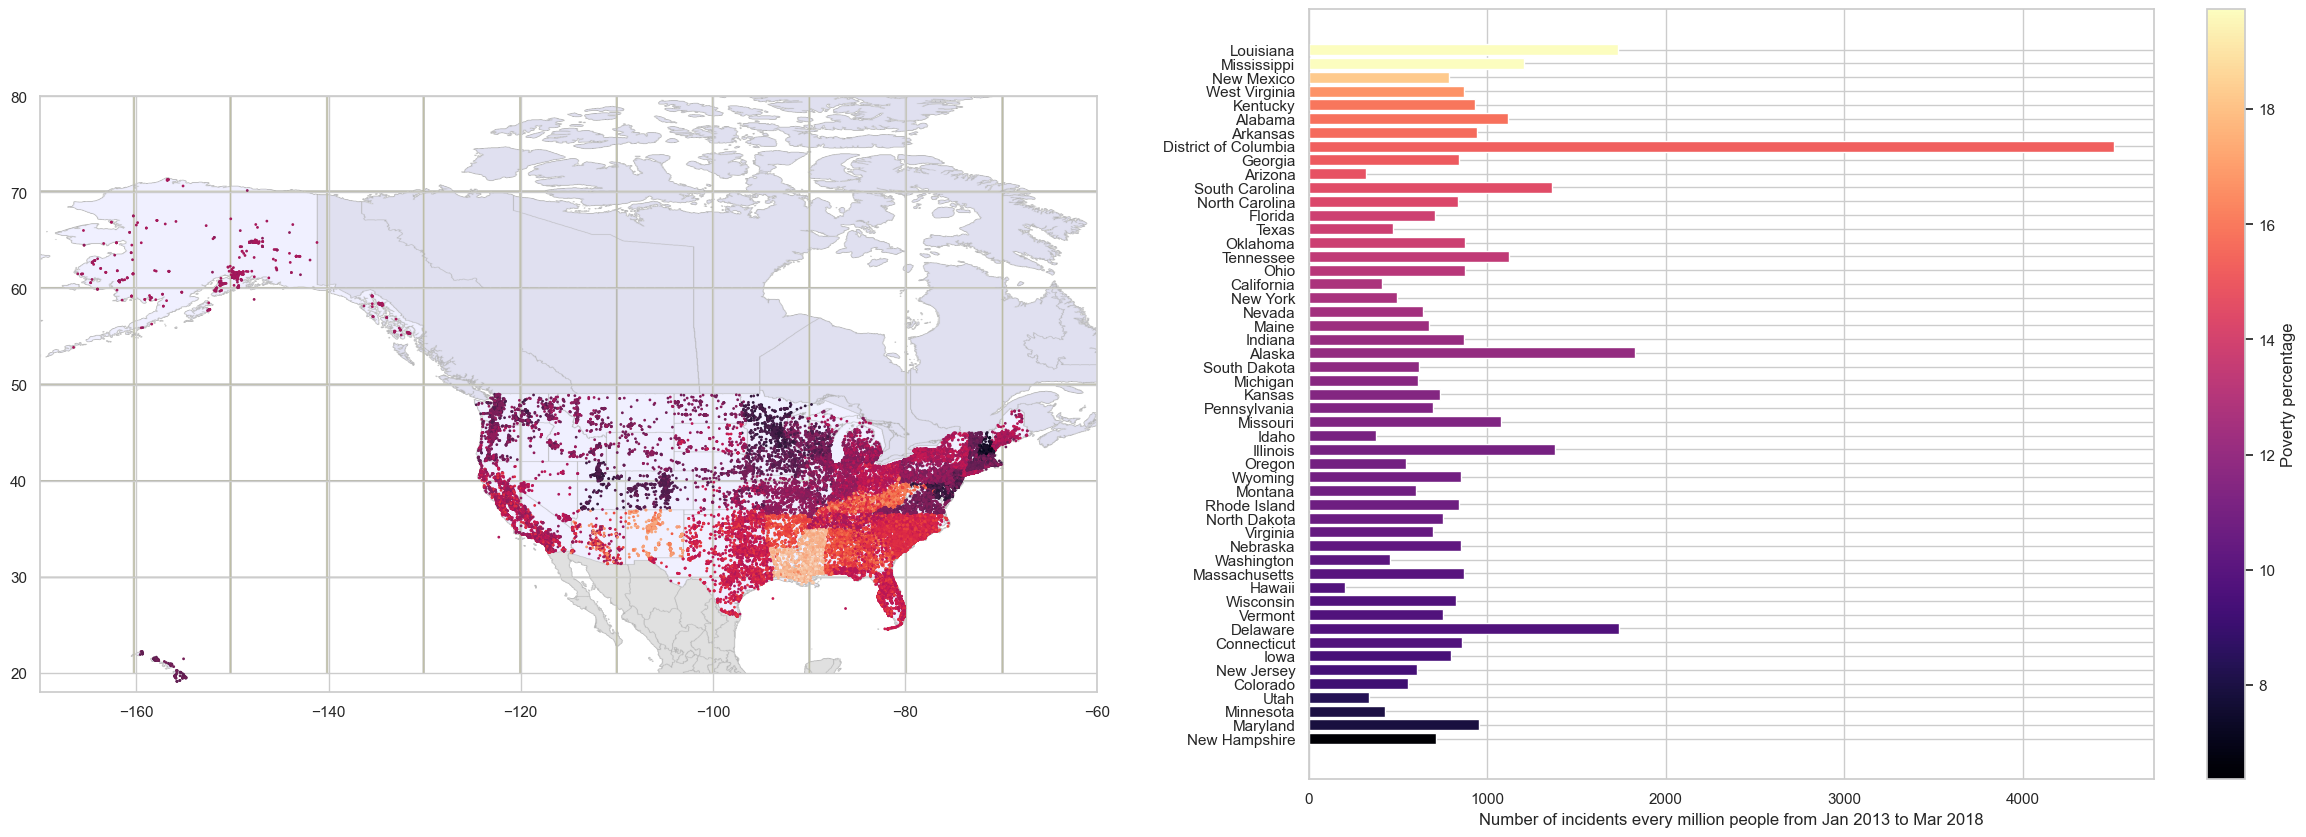

In [2138]:
import matplotlib.cm as cm

sns.set_style("whitegrid")

usa = plt.imread("images/NorthAmerica.png")

fig, axs = plt.subplots(
    1,
    2,
    figsize=(30, 10),
    gridspec_kw={"height_ratios": [1], "width_ratios": [1, 1]},
)

axs[0].imshow(usa, extent=[-180, -60, 20, 80])
scatter = axs[0].scatter(
    [joined_df["longitude"][i] for i in joined_df.index],
    [joined_df["latitude"][i] for i in joined_df.index],
    s=1,
    c=[joined_df["povertyPercentage"][i] for i in joined_df.index],
)

axs[0].set_xlim([-170, -60])
axs[0].set_ylim([18, 80])

####

states = joined_df.sort_values("state", ascending=False)["state"].unique()
incidents_rate = []

poverty = []
for i, value in enumerate(states):
    poverty.append(
        np.mean(joined_df.loc[joined_df["state"] == value]["povertyPercentage"])
    )

sorted_indices = np.argsort(poverty)

# Use sorted indices to reorder both arrays
poverty = [poverty[i] for i in sorted_indices]
states = [states[i] for i in sorted_indices]

cmap = cm.magma
norm = plt.Normalize(min(poverty), max(poverty))
colors = cmap(norm(poverty))
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=axs[1], label="Poverty percentage")

for i, value in enumerate(states):
    count = joined_df.loc[joined_df["state"] == value].shape[0]
    population = population_df[
        (population_df["state"] == value) & (population_df["year"] == 2018)
    ]["population"]
    incidents_rate.append(count / population * 1e6)
    axs[1].barh(value, count / population * 1e6, color=colors[i])

axs[1].set_xlabel("Number of incidents every million people from Jan 2013 to Mar 2018")
sns.set(font_scale=0.5)

## 5. Pairwise correlation

In [2139]:
numerical_columns = [
    "year",
    "latitude",
    "longitude",
    "min_age_participants",
    "avg_age_participants",
    "max_age_participants",
    "children_ratio",
    "teen_ratio",
    "adults_ratio",
    "males_ratio",
    "females_ratio",
    "killed_ratio",
    "injured_ratio",
    "arrested_ratio",
    "unharmed_ratio",
    "n_participants",
    "povertyPercentage",
    "votes_ratio",
]

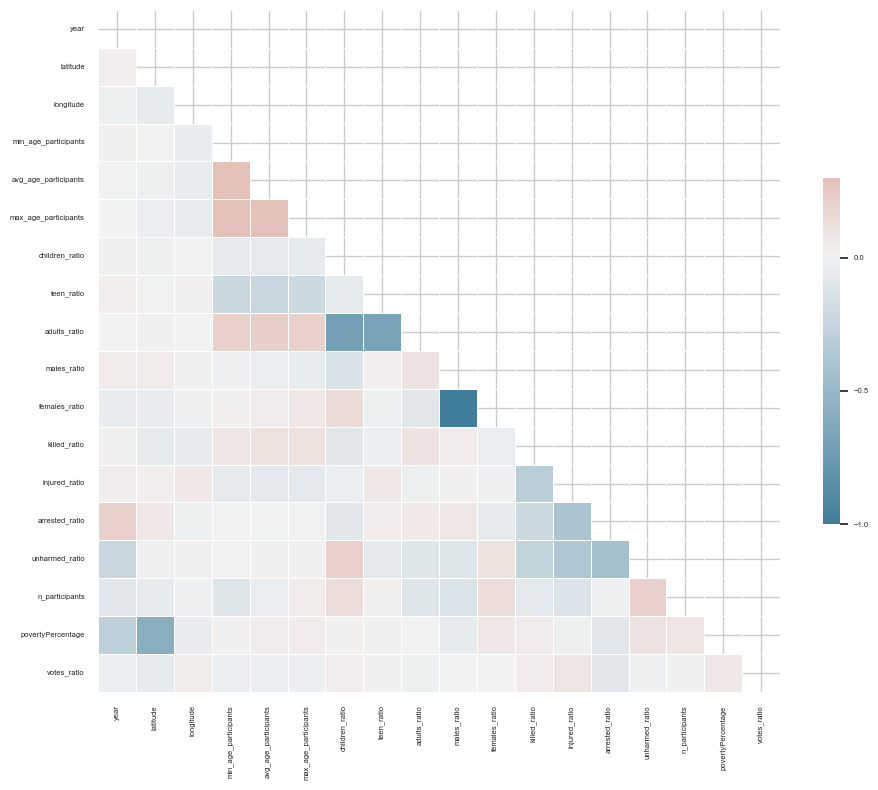

In [2140]:
sns.set_style("whitegrid")
# Compute the correlation matrix
corr = joined_df[numerical_columns].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=0.3,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
)

sns.set(font_scale=2)

In [2160]:
joined_df.drop("females_ratio", axis=1, inplace=True)
joined_df.drop("children_ratio", axis=1, inplace=True)
joined_df.drop("unharmed_ratio", axis=1, inplace=True)

## 6. Summary

In [2161]:
final_df = joined_df.copy()

In [2162]:
final_df.isna().sum() / joined_df.shape[0] * 100

month                   0.0
year                    0.0
state                   0.0
latitude                0.0
longitude               0.0
min_age_participants    0.0
avg_age_participants    0.0
max_age_participants    0.0
teen_ratio              0.0
adults_ratio            0.0
males_ratio             0.0
killed_ratio            0.0
injured_ratio           0.0
arrested_ratio          0.0
n_participants          0.0
povertyPercentage       0.0
party                   0.0
votes_ratio             0.0
totalvotes              0.0
population              0.0
dtype: float64

Encodings

In [2164]:
final_df = pd.get_dummies(final_df, columns=["state"])

In [2165]:
final_df.loc[final_df["party"] == "DEMOCRAT", "party"] = 0
final_df.loc[final_df["party"] == "REPUBLICAN", "party"] = 1

In [2166]:
final_df["month_x"] = np.sin(final_df["month"] * 2 * np.pi / 12)
final_df["month_y"] = np.cos(final_df["month"] * 2 * np.pi / 12)
final_df.drop("month", axis=1, inplace=True)

In [2163]:
final_df

,month,year,state,latitude,longitude,min_age_participants,avg_age_participants,max_age_participants,teen_ratio,adults_ratio,males_ratio,killed_ratio,injured_ratio,arrested_ratio,n_participants,povertyPercentage,party,votes_ratio,totalvotes,population
0,5,2015.0,Indiana,39.8322,-86.2492,19.0,19.0,19.0,0.0,1.000000,1.000000,0.0,1.0,0.0,1,12.3,DEMOCRAT,0.547323,112261.0,6611442
1,4,2017.0,Pennsylvania,41.6645,-78.7856,62.0,62.0,62.0,0.0,1.000000,1.000000,1.0,0.0,0.0,1,10.5,REPUBLICAN,0.671644,307843.0,12794679
2,11,2016.0,Michigan,42.4190,-83.0393,58.0,58.0,58.0,0.0,1.000000,0.500000,0.0,0.5,0.0,2,11.0,DEMOCRAT,0.785066,310974.0,9954117
3,10,2016.0,District of Columbia,38.9030,-76.9820,17.0,17.0,18.0,0.0,0.500000,0.500000,0.0,0.5,0.0,2,14.9,DEMOCRAT,0.740947,302464.0,687576
4,6,2015.0,Pennsylvania,40.4621,-80.0308,55.0,55.0,55.0,0.0,0.500000,0.500000,0.0,0.5,0.0,2,11.5,DEMOCRAT,1.000000,148351.0,12789838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239376,1,2016.0,Tennessee,35.8624,-86.3695,49.0,50.0,50.0,0.0,1.000000,1.000000,0.0,1.0,0.0,1,12.6,REPUBLICAN,0.650341,254937.0,6651277
239377,1,2014.0,New York,42.7043,-73.6590,29.0,29.0,30.0,0.0,0.666667,0.666667,0.0,0.0,0.0,3,13.4,DEMOCRAT,0.487991,211965.0,19653431
239378,8,2017.0,Tennessee,35.1007,-89.9700,58.0,58.0,58.0,0.0,1.000000,1.000000,0.0,1.0,0.0,1,12.1,DEMOCRAT,0.787453,217957.0,6714748
239379,6,2016.0,Colorado,38.8251,-104.8020,68.0,68.0,68.0,0.0,0.500000,1.000000,0.0,0.0,0.5,2,8.9,REPUBLICAN,0.622788,361993.0,5543844


In [2167]:
final_df.to_csv("data/final_dataset.csv", index=False)